 <h1><center> <font color='green'>CNN-TL_MobileNetv2
 </font></center></h1> 

 <h1><center> <font color='blue'>Librerías</font></center></h1>

In [1]:
"""Importar librerias para realizar CNN"""
import os
"""Cargar las imagenes"""
import cv2
from PIL import Image
import rembg
"""Tensoflow para las redes neuronales"""
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
"""Librería para calculo numerico"""
import numpy as np
"""Libreria para graficas"""
import matplotlib.pyplot as plt
"""Importa para dividir el conjunto de datos en entrenamiento y prueba"""
from sklearn.model_selection import train_test_split
"""Librería que que ofrece metricas"""
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
"""Importa datos de señales de registro de archivos de ejecuciones
de simulación disponibles para la aplicación en tiempo real seleccionadas"""
import time
import math
import logging

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2023-07-20 15:23:38.177702: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 15:23:38.221773: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-20 15:23:38.222516: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-20 15:23:38.986034: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h1><center> <font color='orange'>Carga y exploración de datos</font></center></h1> 

In [2]:
"""Definición del tamaño, array de las imagenes"""
IMG_SHAPE  = 224
batch_size = 32
random_seed = 9

In [3]:
#Carga de datos
filespath = './DATASET CACAO'
DestinePath= './DATASET CACAO SF'
categorias = os.listdir(filespath)
#Ordenar Fases
categorias.sort()
print("List of categories = ",categorias,"\n\nNo. of categories = ", len(categorias))

List of categories =  ['FASE 0', 'FASE 1', 'FASE 2', 'FASE 3', 'FASE 4', 'FASE 5', 'FASE 6'] 

No. of categories =  7


### Load Images

In [4]:
def load_images_and_labels(categorias):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categorias):
        for image_name in os.listdir(filespath+"/"+category):
            img = cv2.imread(filespath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')
            img_lst.append(np.array(img_array))
            labels.append(index)
    return img_lst, labels
"""Cargar las imagenes desde las categorias"""
images, labels = load_images_and_labels(categorias)
"""Mostrar la cantidad de imagenes cargadas"""
print("Nº de imágenes cargadas = ",len(images),"\nNo. de etiquetas cargadas = ",len(labels))
print(type(images),type(labels))

Nº de imágenes cargadas =  1400 
No. de etiquetas cargadas =  1400
<class 'list'> <class 'list'>


In [5]:
"""Variables para ver el array de las imagenes y los label"""
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1400, 224, 224, 3) 
Labels shape =  (1400,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


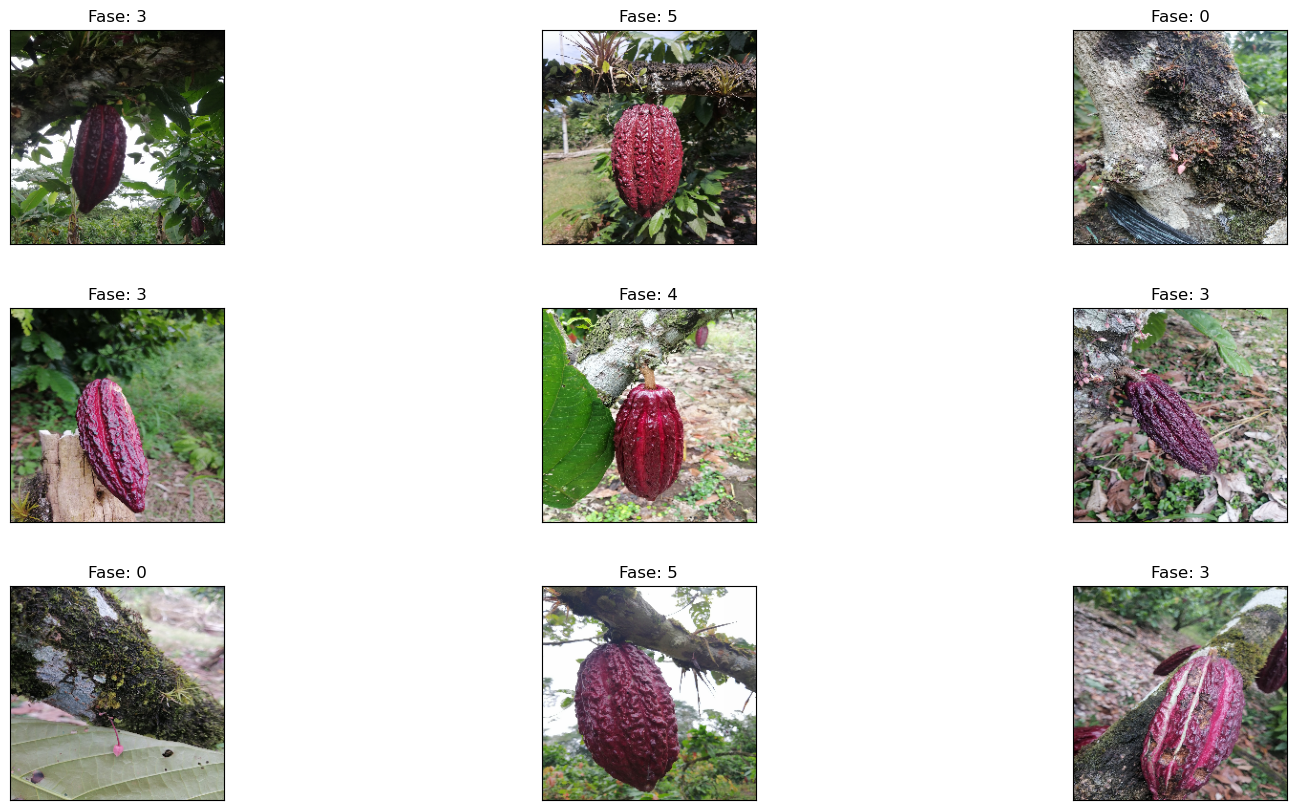

In [6]:
"""Función para visualizar imagenes aleatorias """
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)    
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        plt.title('Fase: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])  
    plt.show()
"""Mostrar imagenes con sus labels"""
display_rand_images(images, labels)

<h1><center> <font color='brow'>Definición del conjunto de datos para pruebas y entrenamiento</font></center></h1>

In [7]:
"""Primero se reorganizan los datos"""

"""Obtener números igualmente espaciados en un rango dado"""
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

"""Mezclar todos los valores igualmente espaciados en la lista 'n'"""
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1397 1398 1399]

'n' values after shuffling =  [ 196 1358  271 ...  638  348  382]


### Shuffling

In [8]:
"""El segundo paso es la mezcla de datos"""

"""imágenes aleatorias y datos de etiquetas correspondientes en ambas listas"""
images = images[n]
labels = labels[n]

print("Forma de las imágenes después de la mezcla = ",images.shape,"\nForma de las etiquetas después de mezclar= ",labels.shape)

Forma de las imágenes después de la mezcla =  (1400, 224, 224, 3) 
Forma de las etiquetas después de mezclar=  (1400,)


### Normalización

In [9]:
"""Normalizacion de los datos, segun su tipo: float, int"""
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Forma de las imágenes después de la normalización = ",images.shape)

Forma de las imágenes después de la normalización =  (1400, 224, 224, 3)


# Training and Testing

In [10]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]
print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)


print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (1062, 224, 224, 3)
y_train shape =  (1062,)

x_test shape =  (280, 224, 224, 3)
y_test shape =  (280,)

x_val shape =  (58, 224, 224, 3)
y_val shape =  (58,)


In [11]:
"""Estructura One-hot-encode"""
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)
y_val = to_categorical(y_val, 7)


 <h1><center> <font color='purple'>Implementación del modelo CNN con MobileNetV2</font></center></h1> 

In [37]:
"""Función para el pre-entrenamiento del modelo, con MobileNetV2"""
pre_trained_model = tf.keras.applications.MobileNetV2(input_shape=x_train[0].shape, include_top=False, weights="imagenet")


In [38]:
"""Pre-entrenar el modelo por capas"""
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False

input_3
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
block_6_expand

In [39]:
"""Configuracion de la ultima capa y la capa de salida"""
last_layer = pre_trained_model.get_layer('out_relu')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(7, activation='softmax')(x)
model = tf.keras.Model(pre_trained_model.input, x)


In [40]:
"""Configuracion para compilar el modelo, tambien se optimiza"""
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [41]:
"""Estructuras los espoch y su tamaño"""
steps_per_epoch = (x_train.shape[0]//batch_size)
"""Validar los pesos"""
validation_steps = (x_val.shape[0] // batch_size)
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1,patience= 10)

# Entrenamiento del Modelo

In [42]:
"""Función de inicio del tiempo"""
start_time = time.time()

"""Estructura de los historys para el entrenamiento del modelo"""
history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

Epoch 1/50
33/33 [==============================] - 9s 201ms/step - loss: 6.1890 - acc: 0.4025 - val_loss: 0.9415 - val_acc: 0.5938
Epoch 2/50
33/33 [==============================] - 5s 160ms/step - loss: 0.8950 - acc: 0.6563 - val_loss: 0.4855 - val_acc: 0.8438
Epoch 3/50
33/33 [==============================] - 5s 158ms/step - loss: 0.7359 - acc: 0.7107 - val_loss: 0.5209 - val_acc: 0.8125
Epoch 4/50
33/33 [==============================] - 5s 151ms/step - loss: 0.6423 - acc: 0.7456 - val_loss: 0.4188 - val_acc: 0.8750
Epoch 5/50
33/33 [==============================] - 5s 153ms/step - loss: 0.5552 - acc: 0.7748 - val_loss: 0.4603 - val_acc: 0.8125
Epoch 6/50
33/33 [==============================] - 5s 148ms/step - loss: 0.5243 - acc: 0.7971 - val_loss: 0.3363 - val_acc: 0.9062
Epoch 7/50
33/33 [==============================] - 5s 150ms/step - loss: 0.4150 - acc: 0.8350 - val_loss: 0.3703 - val_acc: 0.8438
Epoch 8/50
33/33 [==============================] - 5s 149ms/step - loss: 0.

In [54]:
"""Crear un archivo de tipo json"""
model_json = model.to_json()
with open("(92%)MobileNetv2_Vocales_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("(92%)MobileNetv2_Vocales_Classifier.h5")
"""Guardar en el disco duro"""
print("Saved model to disk")
model.save_weights("(92%)MobileNetv2_Vocales.h5")

/opt/conda/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


# Evaluación del modelo

In [43]:
"""Función de inicio del tiempo"""
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Tiempo de ejecución de la evaluación: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

9/9 [==============================] - 1s 157ms/step - loss: 0.2553 - acc: 0.9214
test_loss: 25.53
test_accuracy: 92.14


### Métricas de Evaluación

In [44]:
"""Función para las pruebas del modelo"""
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
"""predecir clases nítidas para el conjunto de prueba"""
model_classes = np.argmax(model_probs,axis=1)
"""reducir a matriz 1d"""
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
"""Accuracy: (tp + tn) / (p + n)"""
accuracy = accuracy_score(y_test_reduced, model_classes)*100
"""Precision tp / (tp + fp)"""
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
"""Recall: tp / (tp + fn)"""
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
"""F1: 2 tp / (2 tp + fp + fn)"""
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 92.14
F1 score: 92.16
Precision: 92.53
Recall: 92.14


## Gráfica de los History

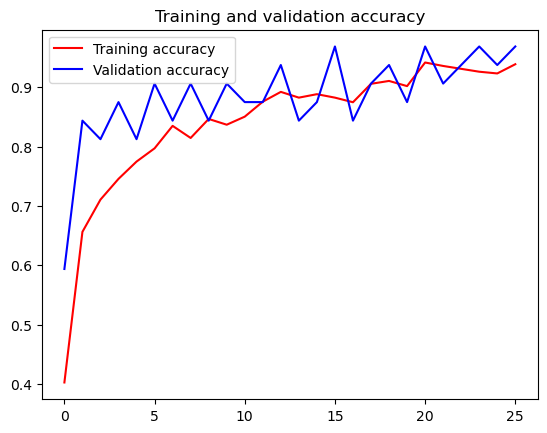

In [45]:
"""Funciones para graficar los history de validacion y el accuracy"""
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - CNN-based TLMobileNetv2.png")
plt.show()

In [46]:
"""Predicción del Modelo"""
y_pred = model.predict(x_test)

9/9 [==============================] - 1s 144ms/step


In [47]:
"""Mostrar el array del y_pred"""
y_pred.round()

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [48]:
"""Visualizar las métricas del modelo"""
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_pred.round(), y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       0.91      0.95      0.93        43
           2       0.90      0.95      0.92        37
           3       0.89      0.91      0.90        35
           4       0.82      0.98      0.89        43
           5       0.85      0.85      0.85        39
           6       1.00      0.91      0.95        46

   micro avg       0.90      0.93      0.92       271
   macro avg       0.91      0.94      0.92       271
weighted avg       0.91      0.93      0.92       271
 samples avg       0.90      0.90      0.90       271



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
"""Visualización del Accuracy"""
accuracy = model.evaluate(x_test,y_test,batch_size=32)
print("Accuracy: ",accuracy[1]*100)

9/9 [==============================] - 1s 145ms/step - loss: 0.2553 - acc: 0.9214
Accuracy:  92.14285612106323


In [50]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1)

In [51]:
"""Reporte de clasificación de las métricas"""
report = classification_report(Y_true, Y_pred_classes, target_names=categorias)
print(report)

              precision    recall  f1-score   support

      FASE 0       1.00      1.00      1.00        28
      FASE 1       0.95      0.93      0.94        45
      FASE 2       0.95      0.90      0.92        39
      FASE 3       0.89      0.92      0.90        36
      FASE 4       0.98      0.84      0.91        51
      FASE 5       0.81      0.90      0.85        39
      FASE 6       0.89      1.00      0.94        42

    accuracy                           0.92       280
   macro avg       0.93      0.93      0.92       280
weighted avg       0.93      0.92      0.92       280



# Matriz de confusión

In [52]:
"""Estructurar la matriz de confusion"""
confusion = confusion_matrix(Y_true,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[28  0  0  0  0  0  0]
 [ 0 42  1  2  0  0  0]
 [ 0  2 35  2  0  0  0]
 [ 0  0  1 33  0  2  0]
 [ 0  0  0  0 43  6  2]
 [ 0  0  0  0  1 35  3]
 [ 0  0  0  0  0  0 42]]


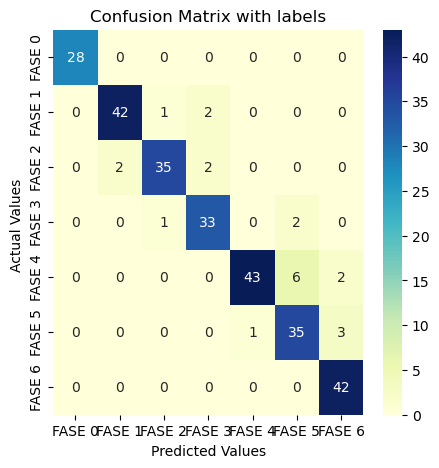

In [53]:
"""Librería para graficar la matriz de confusion"""
import seaborn as sns
plt.figure(figsize=(5, 5))

ma = sns.heatmap(confusion, cmap="YlGnBu", annot=True)
ma.set_title('Confusion Matrix with labels')
ma.set_xlabel('Predicted Values')
ma.set_ylabel('Actual Values ')
ma.xaxis.set_ticklabels(categorias)
ma.yaxis.set_ticklabels(categorias)

plt.show()